## Table of Contents

1. [Importing Packages](#1-importing-packages)
2. [Data Preparation for Modeling](#2-data-preparation-for-modeling)
3. [Baseline Model Evaluation](#3-baseline-model-evaluation)
4. [Hyperparameter Tuning](#4-hyperparameter-tuning)
5. [Final Model Fitting](#5-final-model-fitting)
6. [Model Interpretation](#6-model-interpretation)

## 1. Importing Packages

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report, confusion_matrix


## 2. Data Preparation for Modeling

### Data Splitting

In [128]:
df_modelling = pd.read_csv("../data/stroke_dataset_modelling.csv")

target_col = "stroke"
feature_cols = [col for col in df_modelling.columns if col != target_col]
feature_cols.remove("Unnamed: 0")

X = df_modelling[feature_cols]
y = df_modelling[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify= y)

### Feature Scaling

In [129]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['hypertension', 'heart_disease', "smoking_status", "work_Children", "work_Govt_job"]

preprocessor = ColumnTransformer(
    transformers = [
        ('num', RobustScaler(), numeric_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

During univariate analysis of the numeric features, the boxplot for both `avg_glucose_level` and `bmi` has shown that there were a large number of outliers with skewed distributions. Hence, using a RobustScaler would be more optimal as it is less sensitive to outliers.

## 3. Baseline Model Evaluation

### Model Selection

In [130]:
logreg = LogisticRegression(max_iter= 1000, random_state= 42, class_weight= 'balanced')

knn = KNeighborsClassifier(n_neighbors= 5)

rfclass = RandomForestClassifier(n_estimators = 100, random_state= 42, class_weight = 'balanced')

xgbclass = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42)

### Cross Validation and Evaluation

In [131]:
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

models = {
    'Logistic Regression': (logreg, True),
    'KNN': (knn, True),
    'Random Forest': (rfclass, False),
    'XGBoost': (xgbclass, False)
}

classification_results = {}

for name, (model, needs_scaling) in models.items():

    try:
        if needs_scaling:
            X_data = preprocessor.fit_transform(X_train)
        else:
            X_data = X_train
   
        cv_results = cross_validate(model, X_data, y_train, cv= cv, scoring= scoring, return_train_score= False)

        classification_results[name] = {
            'Precision': cv_results['test_precision'].mean(),
            'Recall': cv_results['test_recall'].mean(),
            'F1': cv_results['test_f1'].mean(),
            'ROC_AUC': cv_results['test_roc_auc'].mean()
        }
    
    except Exception as e:
        print(f"Error with {name}: {e}")
        continue

classification_comparison = pd.DataFrame(classification_results).T
print(classification_comparison)

/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarn

                     Precision    Recall        F1   ROC_AUC
Logistic Regression   0.130422  0.785161  0.223617  0.828413
KNN                   0.066667  0.009302  0.016327  0.657623
Random Forest         0.522619  0.046622  0.082205  0.785207
XGBoost               0.242554  0.088815  0.129152  0.799294


/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:47:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Four classification algorithms were evaluated using a 5-fold stratified cross-validation in order to account for class imbalance. The machine learning models used were: Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost. Cross validation was performed only on the training set in order to prevent data leakage. Both Logistic Regression and KNN models received scaled data as they are distance-sensitive algorithms. On the other hand, Random Forest and XGBoost models receive the original unscaled data as they are tree-based algorithms and do not require scaled data.

In terms of evaluation metrics, accuracy was not used due to class imbalance. As such, alternative metrics were used which were more suitable for imbalanced binary classification:

- Precision: Minimises false stroke predictions
- Recall: Maximises stroke detection rate
- F1 Score: Balance between both precision and recall 
- ROC-AUC: overall discrimiation performance between having and not having stroke

Comparing the evaluation metrics of the 4 models, Logistic Regression stands out as the most optimal model for stroke prediction. Logistic Regression stands out for having the highest ROC-AUC score (0.828413), indicating it has the strongest discriminatory power between whether a patient has or does not have stroke. Although Random Forest models have the highest precision (0.522619), its low recall value (0.046622) makes it unsuitable for stroke detection. On that note, Logistic Regression has the highest recall value (0.785161), which is critical for stroke prediction in order to minimise the number of false negative cases. Overall, Logistic Regression models also has the highest F1 Score (0.223617), achieving the best balance of predicting the most number of stroke incidences correctly while not overwhelming the model with false positives.

## 4. Hyperparameter Tuning

In [132]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ["l1", "l2", "elasticnet"],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    estimator = LogisticRegression(random_state= 42, class_weight= 'balanced'),
    param_grid= param_grid,
    cv = cv,
    scoring = 'f1',
    n_jobs = -1
)

X_train_scaled = preprocessor.fit_transform(X_train)
grid_search.fit(X_train_scaled, y_train)


print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: C

Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Best CV score: 0.2249


/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation

In terms of hyperparameter tuning, GridSearchCV was used to optimise the Logistic Regression model, which has shown the best performance in baseline model evaluation. Simiarly, the same 5-fold stratified approach was used for consistency. The different folds were evaluated based on their F1 Score to maintain focus on balanced precision-recall performance of the model, using only the training set to prevent data leakage. The following hyperparameters were explored to determine the best values to optimise model performance:

- **C:** Refers to regularization strength, which controls overfitting. 
- **penalty:** Refers to the type of regularization, either feature selection or shrinkage
- **solver:** Refers to the optimization algorithm

The GridSearch algorithm has determined that the most optimal set of hyperparameters for LogisticRegression are: 
- **C** = 10
- **penalty** = 'l1'
- **solver** = 'saga'

## 5. Final Model Fitting

In [133]:
final_model = grid_search.best_estimator_
final_model.fit(X_train_scaled, y_train)

X_test_scaled = preprocessor.transform(X_test)

y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)

/Users/nathan/Downloads/Repos/stroke-risk-analysis/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 6. Model Interpretation

### Confusion Matrix & Classification Report

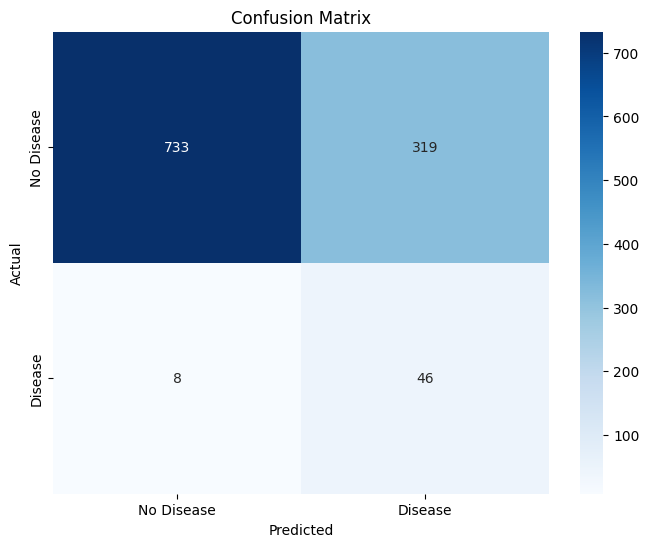

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1052
           1       0.13      0.85      0.22        54

    accuracy                           0.70      1106
   macro avg       0.56      0.77      0.52      1106
weighted avg       0.95      0.70      0.79      1106



In [134]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], 
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print(classification_report(y_test, y_pred))

Combining the results of the classification report and confusion matrix, the model demonstrates a strong ability to detect stroke cases (class 1), as seen in the high recall value of 0.85. This means that the model can correctly identify 85% of actual stroke cases, which is crucial in this medical context where minimising the rate of false negatives is a priority. 

However, the precision for class 1 is low at 0.13, which aligns with the large number of false positives (319) in the confusion matrix. This suggests that the although the model flags many patients as potentially having strokes, a significant portion of those are likely to be incorrect predictions.

The F1-score for class 1 is 0.22, which represents the balance between precision and recall. Although precision is weak, the strong recall drives the F1-score to reflect a model that errs on the side of caution. This is a reasonable trade-off in healthcare screenings, where it is more important to catch as many true stroke cases as possible as opposed to avoiding false alarms.

### Feature Importance

In [135]:
coefficients = grid_search.best_estimator_.coef_[0]  
feature_names = preprocessor.get_feature_names_out()  

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coef_df.sort_values("Coefficient", ascending = False))

                  Feature  Coefficient
0                num__age     2.524260
4      cat__heart_disease     0.903715
6      cat__work_Children     0.881209
3       cat__hypertension     0.644057
1  num__avg_glucose_level     0.584192
5     cat__smoking_status     0.374800
2                num__bmi    -0.129152
7      cat__work_Govt_job    -0.213857


The most impactful features influencing the stroke prediction model were:

- `age`: Strongest positive contributor (+2.52) with older individuals having significantly higher risk of stroke
- `heart_disease`: Second highest positive contributor (+0.90) with any underlying heart diseases increasing the risk of an individual having stroke
- `work_type` = "Children" : Third highest positive contributor (+0.88) which is surprisingly high, suggesting that there is a need for further data investigation
- `hypertension`: Fourth highest positive contributor (+0.64) where individuals with high blood pressure have an increased risk of stroke

### Final Insight

While the model shows strong recall for detecting the risk of stroke (class 1), it comes at the cost of low precision due to a high number of false positives. This trade-off is acceptable in a medical context where identifying as many potential stroke cases as possible is more important than having some healthy individuals misclassified. This model can then be used as a pre-screening tool to flag high-risk individuals based on age, hypertension and heart disease. Thereafter, these patients can undergo further clinical evaluation to have a more reliable assessment of stroke risk. 

In future work, more balanced or enriched data can be collected to ensure that there is a more even spread of data amongst classes to mitigate any class imbalances. Additionally, the modeling process can be adapted to include more ensemble models to better handle any class imbalances.